# Lab Part 4
# Neural Network Model Template

This file contains boilerplate for creating a neural network. Designing a neural network is quite difficult and requires a lot of time to set up data processing pipelines and image processing. As well as making sure that the tensors and datasets are in the correct formats. This file contains all that you need to make your very own neural network.

In [1]:
# Config Parameters for the model
# Set the batch size here 
# increase for systems with more memory, 32 should be enough for most systems
BATCH_SIZE = 32

## Part 1: Unpack our data
All we do is install 7zip and then use pyunpack to extract the files. This saves datasets to /notebooks which is a directory on Paperspace Gradient that is acceptable by python.

In [1]:
# unzip the data

#install dependencies
!apt-get update
!apt-get install -y p7zip-full
!pip install pyunpack
!pip install patool

from pyunpack import Archive
Archive('data.7z').extractall("/notebooks")

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


ValueError: archive file does not exist:e:\programming-dir\dev\source\Demos\Lab Code\Lab Part 4\data.7z

## Part 2: Define where we store our data
This is pretty simple our folder structure looks like this
- data/
    - train/
    - test/

So we simply create 2 variables to store these locations

In [2]:
data_dir = 'data/' # change this to your data directory
train_dir = data_dir + 'train/' # directory for training images
test_dir = data_dir + 'test/' # directory for test images we use the test images to make sure our model is working well

## Part 3: Loading in the data
### Dealing with images
Our image files that we are using for training are pretty large. Your computer may crash if we loaded them all at once so instead we will just store where the images are stored. Later you will see how we can automatically load these files when we run our code. One thing to note is that each image file is named (somenumber).jpg that number is the number of milliseconds since 1 January 1970 (Unix Time) when the file was recorded. This means that we will never have any overlapping files. Unfortunately this does mean we will have to sort the times from smallest to largest to make sure that they correspond with the steering angles which are recorded sequentially.

### Dealing with steering angles
We store our steering values as a csv (comma separated values) file. Python has a built in csv module so we can easily use it to load in all the steering values into a list. These don't take up much ram so it doesn't matter if we load them all in at once. They're just numbers after all.

### Making sure the files line up
Since we sort our images, and the csv file is read in line by line the files will line up with their correct steering angles. It looks something like this. If we mess this up then the data being fed into your network would be totally incoherent. Garbage in Garbage out.

train_img =   | image 1    | image 2    | image 3    | image 4    | image 5    |...

train_steer = | steering 1 | steering 2 | steering 3 | steering 4 | steering 5 |...

In [3]:
import csv
import os
# lets make a function that loads the images and labels
def load_data(directory):
    image__paths = []
    csv_file = ""
    for file in os.listdir(directory): # for each file in the directory
        if file.endswith(".jpg"): # if the file is an image
            image__paths.append(directory + file) # add the image path to the list
        if file.endswith(".csv"): # if the file is a csv file
            csv_file = file # we save it for later

    # now our files are in the train list we need to sort them from smallest file name to largest. The file name is the exact time the image was taken.
    image__paths.sort(key=lambda x: int(x.split('/')[-1][:-4])) # the lambda function returns the numbers in the file name

    # now we need to read the csv file and get the steering angles
    with open(directory + csv_file, 'r') as f:
        reader = csv.reader(f) # create a reader object
        steering_angles = [] # create a list to store the steering angles
        for row in reader: # for each row in the csv file
            steering_angles.append(float(row[0])) # add the steering angle to the list
    return image__paths, steering_angles # return the image paths and steering angles

In [4]:
# We call our load data function to get the image paths and steering angles
train_img, train_steer = load_data(train_dir) # load the training data
test_img, test_steer = load_data(test_dir) # load the test data

## Part 4: Loading in the images

The below code is outside the scope of this course but a brief explanation is provided nevertheless.

### Augmentor
The first step is to create a function that can automatically shift the image in a random way this artificially increases the amount of training data we have access to. This is done by using keras's built in ImageDataGenerator class.

### Preprocess
We create a function that loads in an image path and a steering angle. Then we apply our augmentation and isolate the green tape in the image. Also we randomly flip the image on the x axis and flip the steering values some times as this prevents unbalanced data where the data was captured turning more in one direction than another. This function is implemented using pure tensor operations so it runs a lot faster.

### Dataset Creation
The dataset creation involves the creation of what is known as a dataset pipeline. All this is, is a sequence of transformations applied one after the other that manipulate the data in different ways. 
1. from_tensor_slices. We load in the image paths and the steering angles into the dataset
2. repeat. Simply loop the dataset for infinity when we get to the end. This is done to make sure our network never runs out of data. For instance we train on batches of 32 if we had 52 images we would run out of data.
3. shuffle. Self explanatory makes sure we don't feed network ordered data as this can cause weird issues. Note we don't need to do this with our validation data so we might as well save the unnecessary operation by excluding shuffle.
4. map. Apply the preprocess function to our dataset, Technically we don't actually apply it we just tell the dataset to apply this function when the data is loaded. We also make sure that this function can run in parallel not in series as this is much more efficient.
5. batch. Tell the dataset that when we fetch a item from it is should return a number of items. This is more efficient as you almost certainly have enough RAM to handle more than 1 image.
6. Prefetch. Tell the dataset that when it's not doing anything it should automatically be loading data into RAM in the background. This results in huge performance increases as when we're training we don't have to sit around waiting for the dataset to load and process the images.


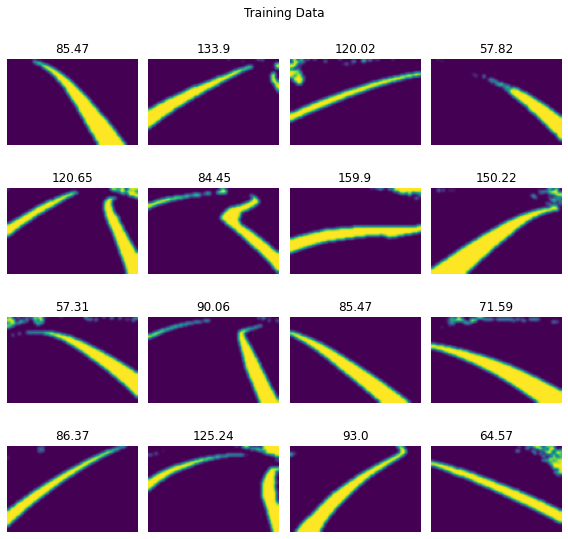

In [94]:
import matplotlib.pyplot as plt # import matplotlib for plotting
import tensorflow as tf
import tensorflow_addons as tfa
import cv2 as cv
import numpy as np

augmentor = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            fill_mode='constant')

@tf.function
def preprocess(img_path, steering):
    img_path, steering = tf.cast(img_path, tf.string), tf.cast(steering, tf.float32)
    img = tf.io.read_file(img_path) # read the image
    img = tf.image.decode_jpeg(img, channels=3) # decode the image
    img = tf.cast(img, tf.float32) # convert the image to a float32 tensor
    hsv = tf.image.rgb_to_hsv(img) # convert the image to hsv
    # normalize the image between 0 and 1
    img = (hsv) / 255.0

    # isolate the hsv values between 40, 10, 60, and 110, 255, 255
    hsv_mask = tf.logical_and(tf.greater(hsv[:,:,0], 0.4), tf.less(hsv[:,:,0], 0.6))
    hsv_mask = tf.logical_and(hsv_mask, tf.greater(hsv[:,:,1], 0.1))
    hsv_mask = tf.logical_and(hsv_mask, tf.less(hsv[:,:,1], 0.9))

    # convert the mask to a float32 tensor
    hsv_mask = tf.cast(hsv_mask, tf.float32)

    # resize the mask 
    # first expand the dimensions of the mask to match the image
    hsv_mask = tf.expand_dims(hsv_mask, axis=-1)
    hsv_mask = tf.image.resize(hsv_mask, (66, 100))

    # blur the image to smooth it
    img = tfa.image.gaussian_filter2d(hsv_mask, [5, 5], 1)

    # generate random int between 0 and 1
    flip_prob = tf.random.uniform(shape=[], minval=0, maxval=1)
    # flip the image horizontally if the random int is less than 0.5
    img = tf.cond(tf.less(flip_prob, 0.5), lambda: tf.image.flip_left_right(img), lambda: img)

    # flip the steering angle if the random int is less than 0.5
    steering = tf.cond(tf.less(flip_prob, 0.5), lambda: 180.0 - steering , lambda: steering)
    
    return img, steering


# create a dataset from the training data and make a data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((train_img, train_steer)) # create a dataset from the image paths and steering angles
train_ds = train_ds.repeat() 
train_ds = train_ds.shuffle(buffer_size=len(train_img)) # shuffle the dataset
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) # map the parse function to the dataset adding parallelism increases performance by over 8 times
train_ds = train_ds.batch(BATCH_SIZE) # batch the dataset
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# create a dataset from the testing data and make a data pipeline
test_ds = tf.data.Dataset.from_tensor_slices((test_img, test_steer)) # create a dataset from the image paths and steering angles
test_ds = test_ds.repeat() # repeat the dataset
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) # map the parse function to the dataset
test_ds = test_ds.batch(BATCH_SIZE) # batch the dataset
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# output the first 16 images and steering angles from the dataset
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(train_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
plt.tight_layout()
plt.show()

## Part 5: This is where you will create your model
try modifying the layers to try to get the lowest mse score,
This is going to require some trial and error so make sure you spend some time experimenting.

In [92]:
import numpy as np
np.random.seed(1337) # for reproducibility
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model. You shouldn't need to change this.
model.add(InputLayer(input_shape=(66, 100, 1), batch_size=BATCH_SIZE))

# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also help

# Also try modifying the Conv2D layers to see how they affect the model and add MaxPool2D layers to the model to reduce the number of parameters in the model

# In this lab we can add Dropout layers to the model to reduce overfitting.
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1 ,activation='linear'))

optimizer = Adam(learning_rate=0.0001) # try changing the learning rate to see how it affects the model

model.compile(optimizer=optimizer, loss='mse') # we will keep track of the mean squared error
print(model.summary()) # print a summary of the model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (32, 64, 98, 32)          320       
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 32, 49, 32)         0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (32, 50176)               0         
                                                                 
 dense_27 (Dense)            (32, 32)                  1605664   
                                                                 
 dense_28 (Dense)            (32, 16)                  528       
                                                                 
 dense_29 (Dense)            (32, 1)                   17        
                                                      

In [93]:
hist = model.fit(train_ds, steps_per_epoch=len(train_img)//BATCH_SIZE, validation_data=test_ds, validation_steps=len(test_img)//BATCH_SIZE, epochs=10) # train the model

Epoch 1/10
 24/156 [===>..........................] - ETA: 1:00 - loss: 8516.6865

KeyboardInterrupt: 

Have a look at the graph generated below. With this you can get an idea of whether your model is training well. You should want to see both lines trend downwards.

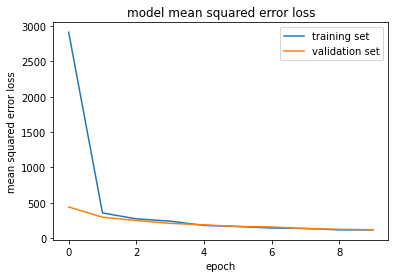

In [77]:
import matplotlib.pyplot as plt

# lets plot the model's history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


## Part 6: Test the model
We'll now output 16 images with the predicted steering angles along with the actual steering angles

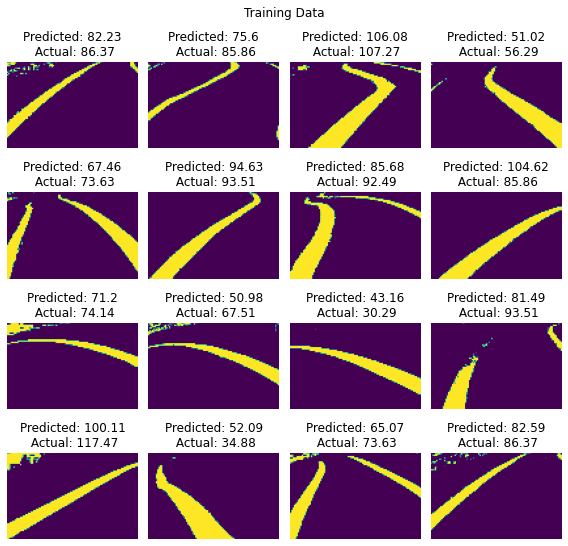

In [78]:
# output the first 16 images and steering angles from the test dataset then predict the steering angle for the images
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(train_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    #axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
    predicted = model(imgs[i].numpy().reshape(1, 66, 100, 1)) # predict the steering angle for the image
    axs[i//4, i%4].set_title("Predicted: " + str(round(predicted[0][0].numpy(), 2)) + "\n Actual: " + str(round(steer[i].numpy(), 2)))
plt.tight_layout()
plt.show()

## Part 7: export your model
Once you are happy with your model you can export it by running the code below.
This will save your model as model.h5. You can change this to be more descriptive. I also recommend saving multiple models with different training settings so you have a couple to experiment with. 

In [14]:
model.save('evenbetter.h5') # save the model change the name to something more descriptive if you want